In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger
from avalanche.benchmarks import nc_benchmark
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
import pickle
import os
from pennylane.qnn import TorchLayer

In [2]:
# 量子电路参数
n_qubits = 8
n_layers = 4
q_depth = 4
q_delta = 0.1

# 量子计算设备设置
dev = qml.device("lightning.qubit", wires=n_qubits)

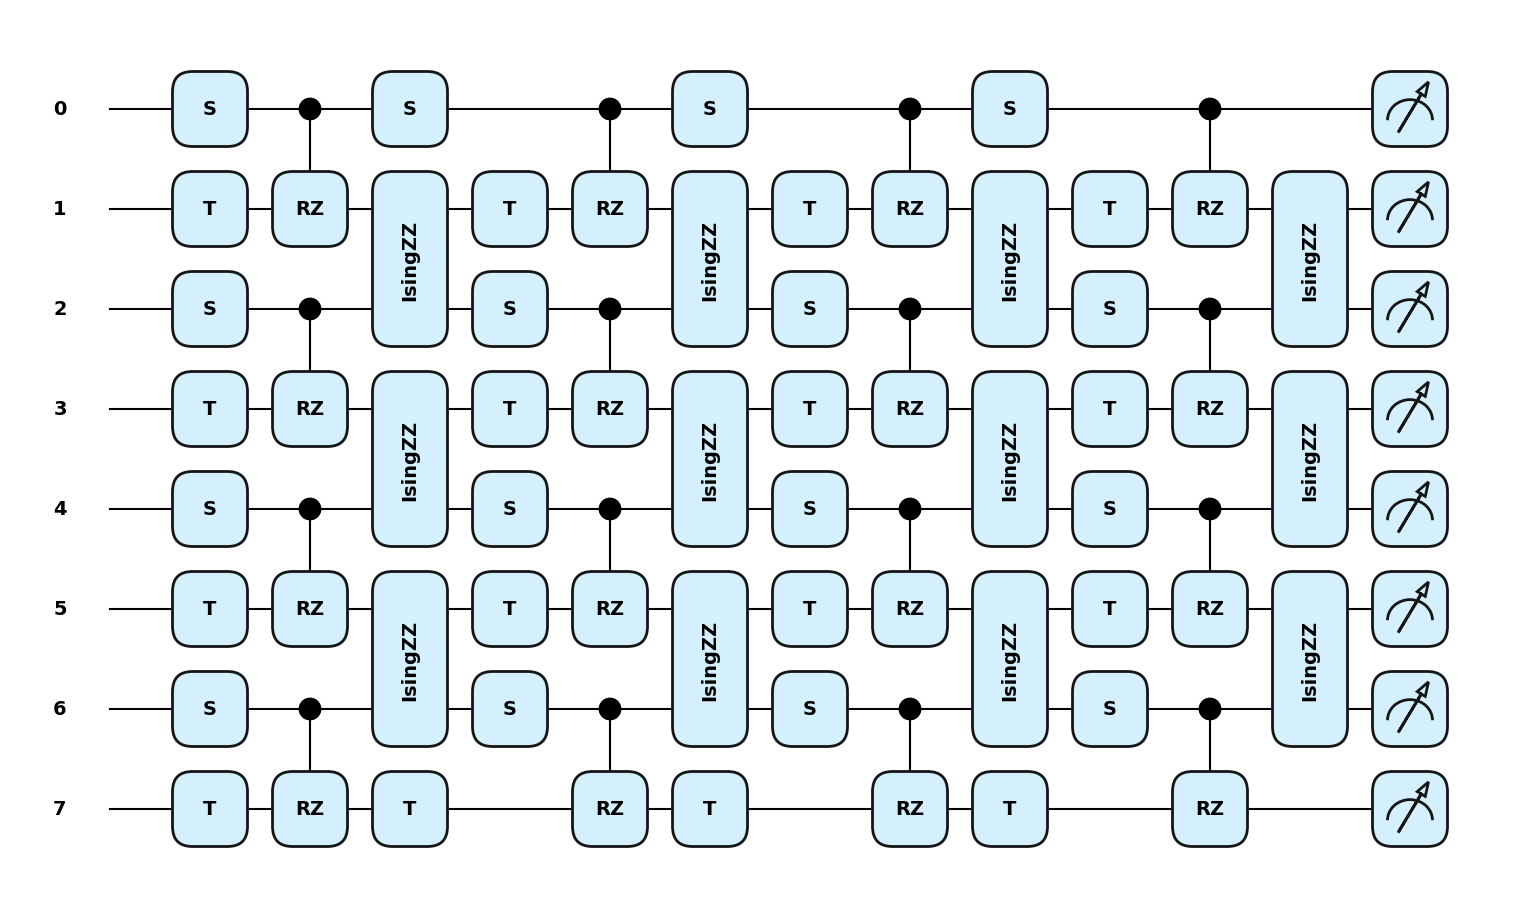

In [ ]:
# 量子电路定义
def phase_layer(w):
    """Layer of S gates and T gates to flip the phase of the qubits."""
    for idx in range(w):
        if idx % 2 == 0:
            qml.S(wires=idx)
        else:
            qml.T(wires=idx)

def entangling_layer_3(nqubits):
    """Layer of controlled-Rz gates followed by zz entangling gates."""
    params = np.random.uniform(0, 2*np.pi, (nqubits,))
    for i in range(0, nqubits - 1, 2):
        qml.ctrl(qml.RZ, control=i)(params[i], wires=i + 1)
    for i in range(1, nqubits - 1, 2):
        qml.IsingZZ(params[i], wires=[i, i + 1])

def measurement_layer(nqubits):
    """Measurement layer in the Z basis."""
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]

# 量子网络定义
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_net_3(q_input_features, q_weights_flat):
    """Quantum circuit for the network."""
    if not isinstance(q_weights_flat, torch.Tensor):
        q_weights_flat = torch.tensor(q_weights_flat, dtype=torch.float32, requires_grad=True)

    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Apply quantum layers
    for _ in range(q_depth):
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)
    
    # Return Pauli-Z expectation values
    exp_val = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_val

# 使用量子电路图
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(quantum_net_3)(torch.randn(n_qubits, q_depth), q_delta * torch.randn(q_depth * n_qubits))
plt.show()

In [46]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
# 量子-经典混合网络
class DressedQuantumNet(nn.Module):
    def __init__(self, n_qubits, n_layers, q_depth, q_delta, num_classes=10):
        super().__init__()
        self.pre_net = nn.Linear(256, n_qubits)  # input 512 to n_qubits
        self.q_params = torch.nn.Parameter(q_delta * torch.randn(q_depth * n_qubits, requires_grad=True))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):
        """Forward pass through the quantum-encoded network."""
        pre_out = self.pre_net(input_features.to(device))
        q_in = torch.tanh(pre_out) * np.pi / 2.0  # Map to quantum input range

        q_out = torch.empty((0, n_qubits), device=device, dtype=torch.float32, requires_grad=True)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net_3(elem, self.q_params)).float().unsqueeze(0).to(device)
            q_out = torch.cat((q_out, q_out_elem), dim=0).requires_grad_(True)

        return self.post_net(q_out)

In [47]:
# Step 1: 加载预处理好的 PCA 数据
with open("/home/yangz2/code/quantum_cl/data/splitmnist_pca256.pkl", 'rb') as f:
    processed = pickle.load(f)

# Step 2: 重构每个经验的 TensorDatasets（train/val）
datasets_by_exp = {}
for vec, label, exp_id in processed:
    datasets_by_exp.setdefault(exp_id, {"X": [], "y": []})
    datasets_by_exp[exp_id]["X"].append(vec)
    datasets_by_exp[exp_id]["y"].append(label)

# Step 3: 将每个 experience 的数据打包为 TensorDatasets
train_datasets = []
test_datasets = []
task_labels = []
for exp_id in sorted(datasets_by_exp):
    X = torch.stack([torch.tensor(v) for v in datasets_by_exp[exp_id]["X"]])
    y = torch.tensor(datasets_by_exp[exp_id]["y"], dtype=torch.long)
    
    # 可选：划分训练集和测试集
    # 在这里我们将训练集和测试集都设置为同一个，您可以按需调整
    ds = TensorDataset(X, y)
    
    train_datasets.append(ds)
    test_datasets.append(ds)  # 或者单独为 test 数据集创建 TensorDataset
    task_labels.append(0)  # 每个经验都使用任务 0，可以根据需要进行修改

# Step 4: 使用 nc_benchmark 创建持续学习基准
benchmark = nc_benchmark(
    train_datasets, 
    test_datasets, 
    n_experiences=len(train_datasets),
    task_labels=task_labels
)

print("✔ 使用预处理好的 PCA 数据创建了 nc_benchmark")

✔ 使用预处理好的 PCA 数据创建了 nc_benchmark


In [48]:
# -----------------------------------------------------------------------------
# 设置训练环境
# -----------------------------------------------------------------------------
model = DressedQuantumNet(n_qubits, n_layers, q_depth, q_delta, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Evaluation setup
interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=10, save_image=False, stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger]
)

In [ ]:
# -----------------------------------------------------------------------------
# 使用 EWC 持续学习策略
# -----------------------------------------------------------------------------
strategy = EWC(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    ewc_lambda=1,
    train_epochs=10,
    device=device,
    evaluator=eval_plugin
)


In [ ]:
# -----------------------------------------------------------------------------
# 开始训练与评估
# -----------------------------------------------------------------------------
task_accuracies = []
save_dir = "/home/yangz2/code/quantum_cl/results/list"
os.makedirs(save_dir, exist_ok=True)

print("Starting training...")
for experience in benchmark.train_stream:
    print(f"\n--- Training on experience {experience.current_experience} ---")
    strategy.train(experience)
    
    print(f"--- Evaluating after experience {experience.current_experience} ---")
    results = strategy.eval(benchmark.test_stream)
    task_accuracies.append(results)
    
    # 保存中间结果
    with open(os.path.join(save_dir, f"interim_results_exp_{experience.current_experience}.pkl"), "wb") as f:
        pickle.dump(task_accuracies, f)

# 保存最终结果
with open(os.path.join(save_dir, "splitmnist_EWC_ours_qbit8_qdepth4_tepoch10.pkl"), "wb") as f:
    pickle.dump(task_accuracies, f)

print("✔ Training and evaluation completed!")

Starting training...

--- Training on experience 0 ---
-- >> Start of training phase << --
0it [00:00, ?it/s]

  8%|▊         | 918/11807 [00:13<02:25, 75.03it/s]

KeyboardInterrupt: 

  8%|▊         | 918/11807 [00:24<02:25, 75.03it/s]